In [7]:
#imports
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, col, sum, mean, stddev, median, year, month, count, concat_ws, sha2, desc, asc, lag, when, lit, round, avg, min, max
from pyspark.sql.window import Window

In [8]:
#initialize Spark
spark = SparkSession.builder \
    .appName("MoneyLaunderingDetectionVisualization") \
    .config("spark.driver.memory", "12g") \
    .config("spark.executor.memory", "16g") \
    .getOrCreate()

23/10/26 16:08:25 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/10/26 16:08:25 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
23/10/26 16:08:25 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
23/10/26 16:08:25 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
23/10/26 16:08:25 WARN Utils: Service 'SparkUI' could not bind on port 4044. Attempting port 4045.
23/10/26 16:08:25 WARN Utils: Service 'SparkUI' could not bind on port 4045. Attempting port 4046.
23/10/26 16:08:25 WARN Utils: Service 'SparkUI' could not bind on port 4046. Attempting port 4047.
23/10/26 16:08:25 WARN Utils: Service 'SparkUI' could not bind on port 4047. Attempting port 4048.
23/10/26 16:08:25 WARN Utils: Service 'SparkUI' could not bind on port 4048. Attempting port 4049.
23/10/26 16:08:25 WARN Utils: Service 'SparkUI' could not bind on port 4049. Attempting port 4050.
23/10/26 1

In [9]:
#define the path to the CSV file with transactions data
csv_file_path = '/common/users/shared/cs543_group4/clean_data/aml_clean_data.csv'

#load the data as a spark df
data_df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

In [10]:
data_df.columns


['timestamp',
 'bank_from',
 'account_from',
 'bank_to',
 'account_to',
 'amount_to',
 'currency_to',
 'amount_from',
 'currency_from',
 'payment_format',
 'is_laundering',
 'month',
 'year',
 'conversion_rate_from',
 'amount_from_usd',
 'conversion_rate_to',
 'amount_to_usd',
 'unique_id_from',
 'unique_id_to']

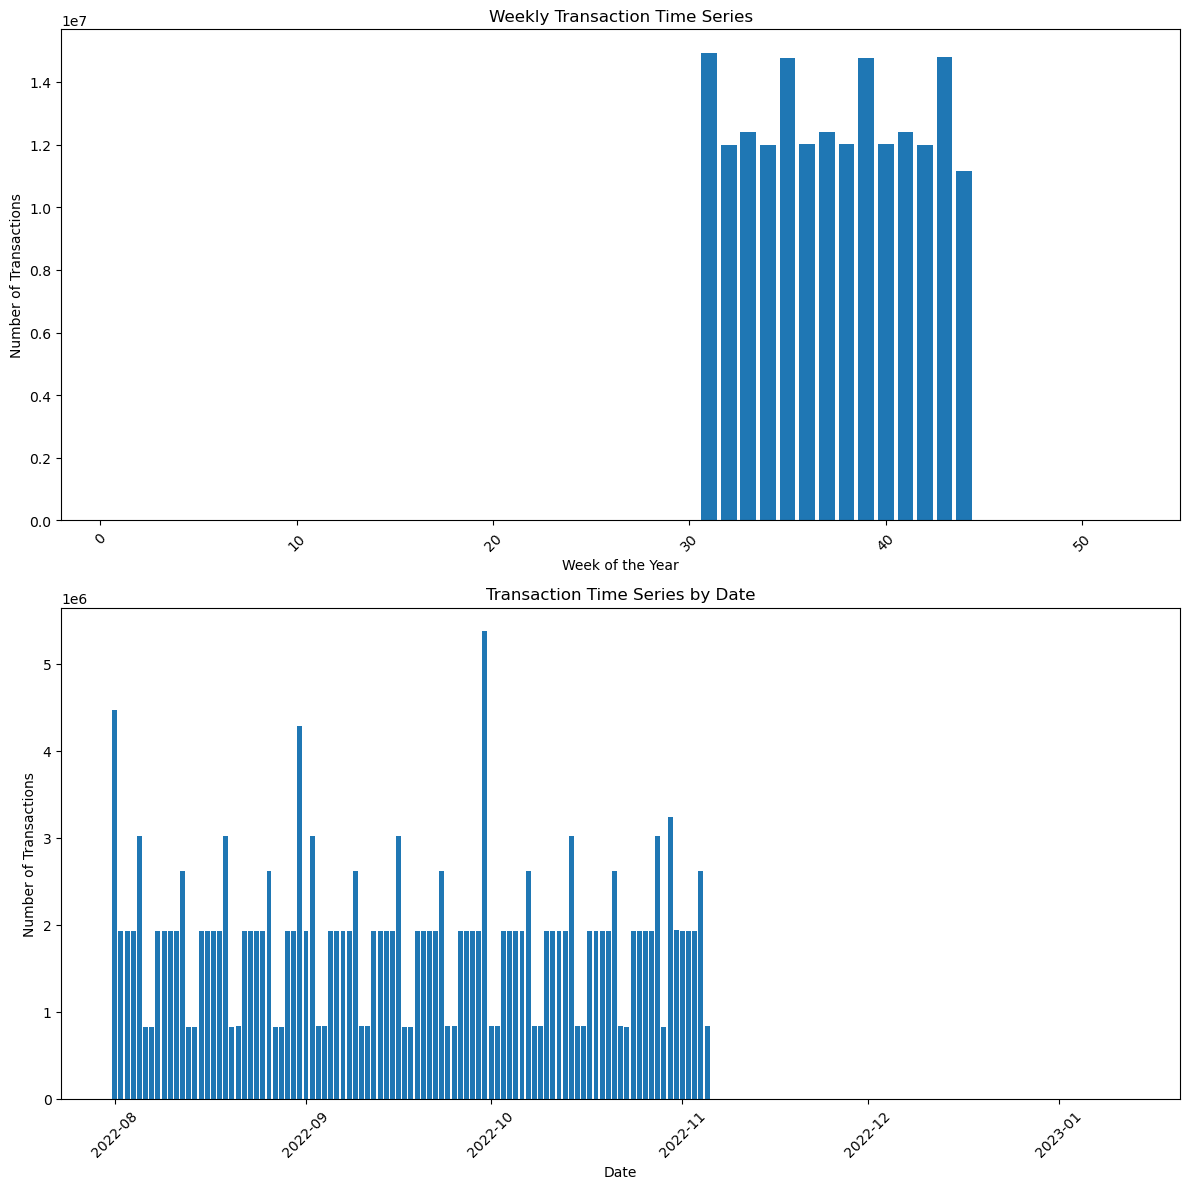

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import functions as F

# Convert timestamp column to date format
data_df = data_df.withColumn("timestamp", F.to_date(data_df["timestamp"], "yyyy/MM/dd HH:mm"))

# Extract week from the timestamp
data_df_week = data_df.withColumn("week", F.weekofyear("timestamp"))

# Group by week and count transactions
transaction_counts_week = data_df_week.groupBy("week").count().orderBy("week")

# Group by timestamp and count transactions
transaction_counts_timestamp = data_df.groupBy("timestamp").count().orderBy("timestamp")

# Convert the results to Pandas for plotting
pandas_df_week = transaction_counts_week.toPandas()
pandas_df_timestamp = transaction_counts_timestamp.toPandas()

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# Plot transactions per week using bar graph
axs[0].bar(pandas_df_week["week"], pandas_df_week["count"])
axs[0].set_xlabel("Week of the Year")
axs[0].set_ylabel("Number of Transactions")
axs[0].set_title("Weekly Transaction Time Series")
axs[0].tick_params(axis='x', rotation=45)

# Plot transactions per timestamp using bar graph
axs[1].bar(pandas_df_timestamp["timestamp"], pandas_df_timestamp["count"])
axs[1].set_xlabel("Date")
axs[1].set_ylabel("Number of Transactions")
axs[1].set_title("Transaction Time Series by Date")
axs[1].tick_params(axis='x', rotation=45)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

# Stop the Spark session
spark.stop()




23/10/26 13:46:45 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/10/26 13:46:45 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
23/10/26 13:46:45 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
23/10/26 13:46:45 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
23/10/26 13:46:45 WARN Utils: Service 'SparkUI' could not bind on port 4044. Attempting port 4045.
23/10/26 13:46:45 WARN Utils: Service 'SparkUI' could not bind on port 4045. Attempting port 4046.
23/10/26 13:46:45 WARN Utils: Service 'SparkUI' could not bind on port 4046. Attempting port 4047.
23/10/26 13:46:45 WARN Utils: Service 'SparkUI' could not bind on port 4047. Attempting port 4048.
23/10/26 13:46:45 WARN Utils: Service 'SparkUI' could not bind on port 4048. Attempting port 4049.
23/10/26 13:46:45 WARN Utils: Service 'SparkUI' could not bind on port 4049. Attempting port 4050.
23/10/26 1

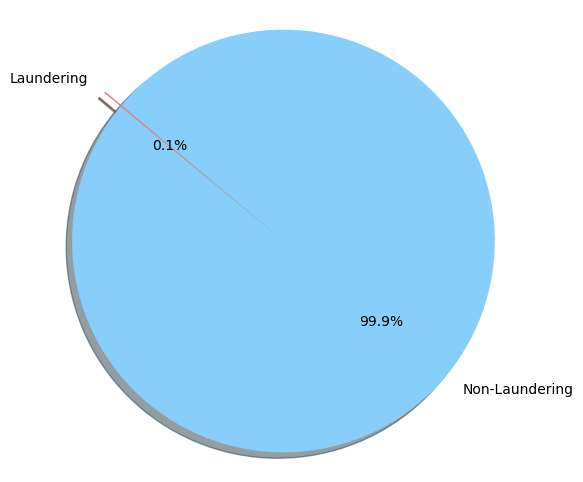

In [14]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName("LaunderingPieChart").getOrCreate()

csv_file_path = '/common/users/shared/cs543_group4/clean_data/aml_clean_data.csv'
data_df = spark.read.csv(csv_file_path, header=True, inferSchema=True)


possible_column_names = ["Is Laundering", "is_laundering", "IS_LAUNDERING"]
actual_column_name = None

for col_name in possible_column_names:
    if col_name in data_df.columns:
        actual_column_name = col_name
        break

if actual_column_name is None:
    raise ValueError("Column name 'Is Laundering' not found in the DataFrame.")

# Filter the DataFrame to separate laundering and non-laundering transactions
laundering_count = data_df.filter(col(actual_column_name) == 1).count()
non_laundering_count = data_df.filter(col(actual_column_name) == 0).count()

# Create labels and sizes for the pie chart
labels = ["Laundering", "Non-Laundering"]
sizes = [laundering_count, non_laundering_count]
colors = ["lightcoral", "lightskyblue"]
explode = (0.1, 0)  # Explode the 1st slice (Laundering)
# Set the figure size
plt.figure(figsize=(6, 6))

# Create a pie chart
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

# Equal aspect ratio ensures that the pie chart is drawn as a circle
plt.axis('equal')

# Show the pie chart
plt.show()

# Stop the Spark session
spark.stop()

23/10/26 13:50:48 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/10/26 13:50:48 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
23/10/26 13:50:48 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
23/10/26 13:50:48 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
23/10/26 13:50:48 WARN Utils: Service 'SparkUI' could not bind on port 4044. Attempting port 4045.
23/10/26 13:50:48 WARN Utils: Service 'SparkUI' could not bind on port 4045. Attempting port 4046.
23/10/26 13:50:48 WARN Utils: Service 'SparkUI' could not bind on port 4046. Attempting port 4047.
23/10/26 13:50:48 WARN Utils: Service 'SparkUI' could not bind on port 4047. Attempting port 4048.
23/10/26 13:50:48 WARN Utils: Service 'SparkUI' could not bind on port 4048. Attempting port 4049.
23/10/26 13:50:48 WARN Utils: Service 'SparkUI' could not bind on port 4049. Attempting port 4050.
23/10/26 1

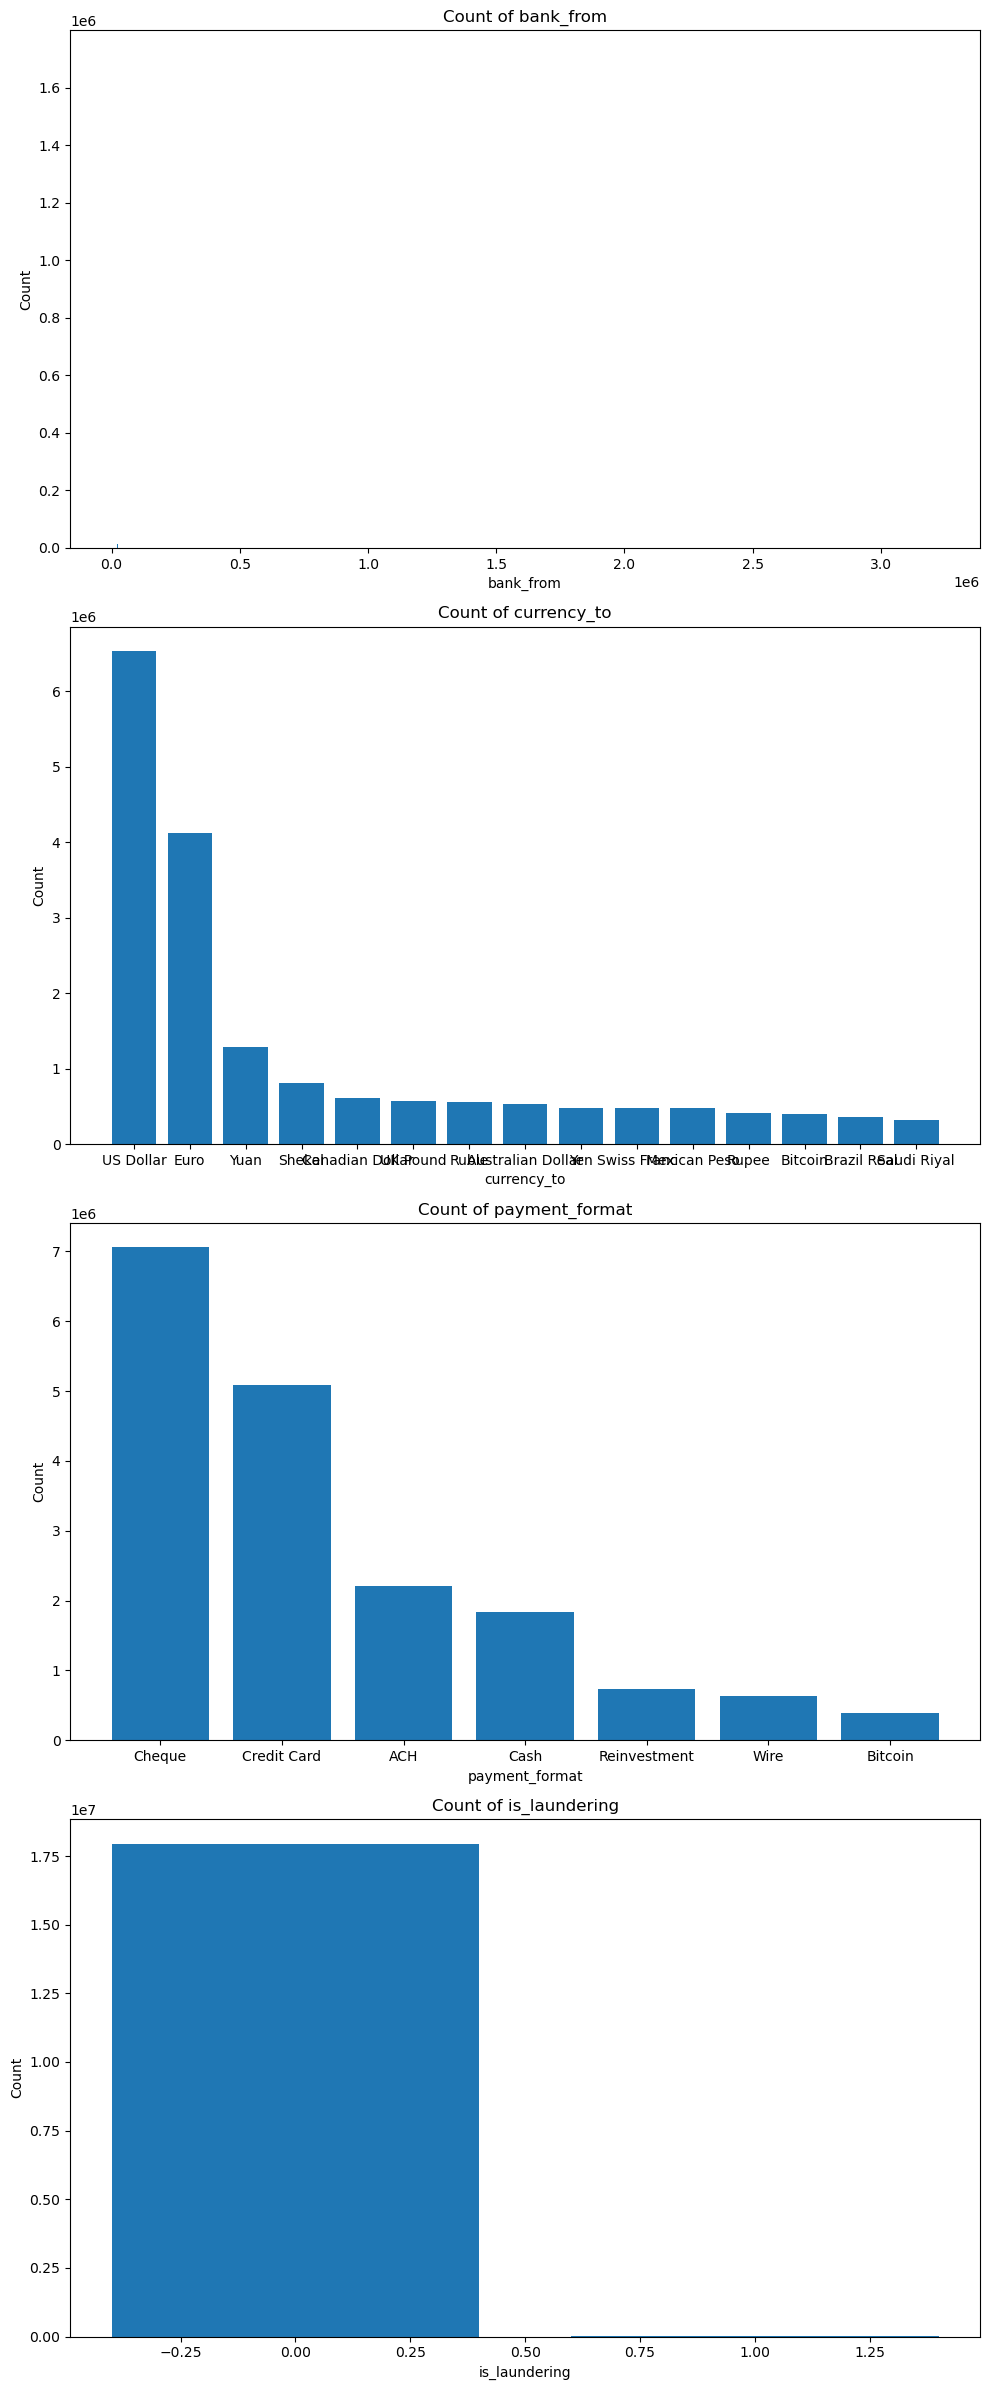

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

spark = SparkSession.builder.appName("VizPieChart").getOrCreate()

csv_file_path = '/common/users/shared/cs543_group4/clean_data/aml_clean_data.csv'
data_df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

# List of categorical columns
categorical_columns = ['bank_from', 'currency_to', 'payment_format', 'is_laundering']

# Sample a fraction of your data for visualization
sample_fraction = 0.1  # Adjust as needed
sampled_data_df = data_df.sample(withReplacement=False, fraction=sample_fraction, seed=42)

# Collect the sampled data from the Spark DataFrame to the driver node and convert to a Pandas DataFrame
data_pd = sampled_data_df.select(categorical_columns).toPandas()

# Set up subplots for multiple bar charts
fig, axes = plt.subplots(len(categorical_columns), 1, figsize=(10, 6 * len(categorical_columns)))

for i, col in enumerate(categorical_columns):
    # Count unique values and sort by count
    value_counts = data_pd[col].value_counts().sort_values(ascending=False)
    
    # Plot the bar chart
    axes[i].bar(value_counts.index, value_counts.values)
    axes[i].set_title(f'Count of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

# Adjust layout and display the charts
plt.tight_layout()
plt.show()


In [16]:
# Calculate the transaction count for each unique 'currency_from' and 'currency_to' pair
currency_from_counts = data_df.groupBy("currency_from").count()
currency_to_counts = data_df.groupBy("currency_to").count()

# Calculate the percentage of transactions for each category
total_count = data_df.count()
currency_from_counts = currency_from_counts.withColumn("currency_from_perc", (currency_from_counts["count"] / total_count) * 100)
currency_to_counts = currency_to_counts.withColumn("currency_to_perc", (currency_to_counts["count"] / total_count) * 100)

# Convert the PySpark DataFrames to Pandas DataFrames for plotting
currency_from_pandas_df = currency_from_counts.toPandas()
currency_to_pandas_df = currency_to_counts.toPandas()

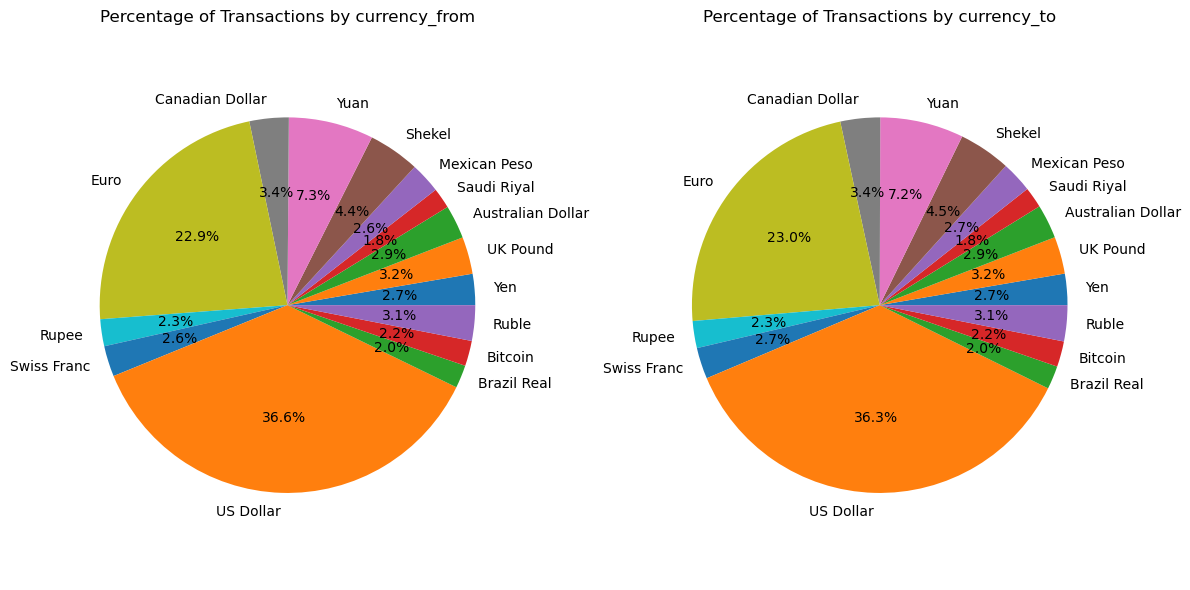

In [17]:
import matplotlib.pyplot as plt

# Create pie charts for 'currency_from' and 'currency_to'
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.pie(currency_from_pandas_df["currency_from_perc"], labels=currency_from_pandas_df["currency_from"], autopct='%1.1f%%')
plt.title("Percentage of Transactions by currency_from")
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.pie(currency_to_pandas_df["currency_to_perc"], labels=currency_to_pandas_df["currency_to"], autopct='%1.1f%%')
plt.title("Percentage of Transactions by currency_to")
plt.axis('equal')

# Show the pie charts
plt.tight_layout()
plt.show()

In [29]:
from pyspark.sql.functions import col

# Redo currency calculations for only transactions that are laundering
currency_from_counts_launder = data_df.select(col('is_laundering'), col('currency_from')).filter(col('is_laundering') == 1).groupBy("currency_from").count()
currency_to_counts_launder = data_df.select(col('is_laundering'), col('currency_to')).filter(col('is_laundering') == 1).groupBy("currency_to").count()


currency_from_counts_launder_total = currency_from_counts_launder.count()
currency_to_counts_launder_total = currency_to_counts_launder.count()

currency_from_counts_launder = currency_from_counts_launder.withColumn("currency_from_launder_perc", (currency_from_counts_launder["count"] / currency_from_counts_launder_total) * 100)
currency_to_counts_launder = currency_to_counts_launder.withColumn("currency_to_launder_perc", (currency_to_counts_launder["count"] / currency_to_counts_launder_total) * 100)

currency_from_launder_pandas_df = currency_from_counts_launder.toPandas()
currency_to_launder_pandas_df = currency_to_counts_launder.toPandas()

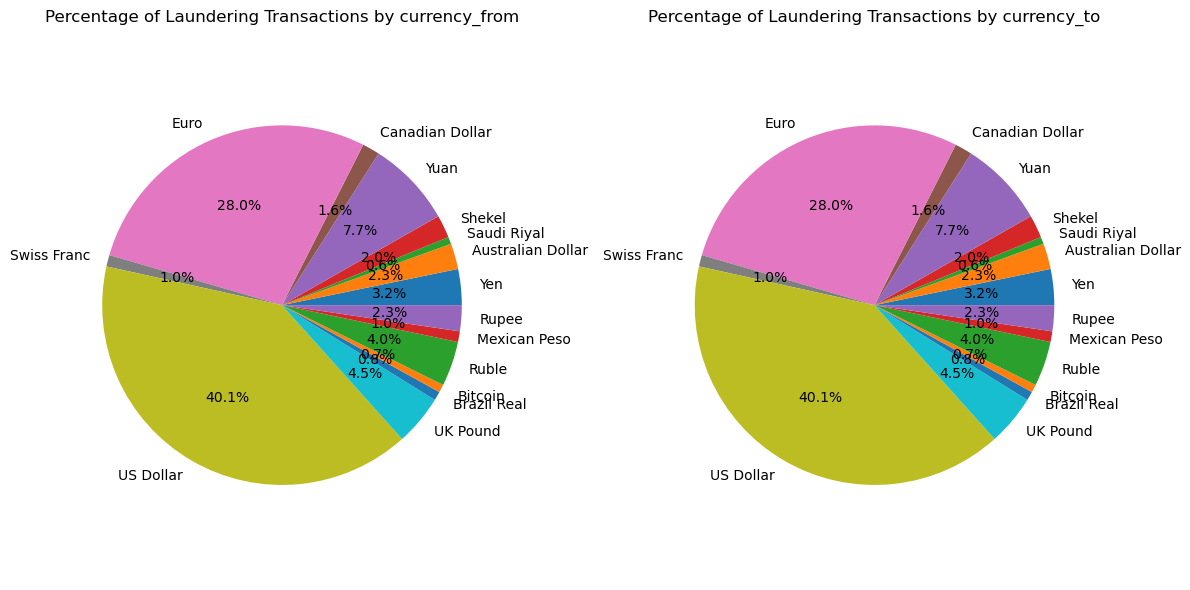

In [30]:
#Create pie charts for laundering transactions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.pie(currency_from_launder_pandas_df["currency_from_launder_perc"], labels=currency_from_launder_pandas_df["currency_from"], autopct='%1.1f%%')
plt.title("Percentage of Laundering Transactions by currency_from")
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.pie(currency_to_launder_pandas_df["currency_to_launder_perc"], labels=currency_to_launder_pandas_df["currency_to"], autopct='%1.1f%%')
plt.title("Percentage of Laundering Transactions by currency_to")
plt.axis('equal')

# Show the pie charts
plt.tight_layout()
plt.show()

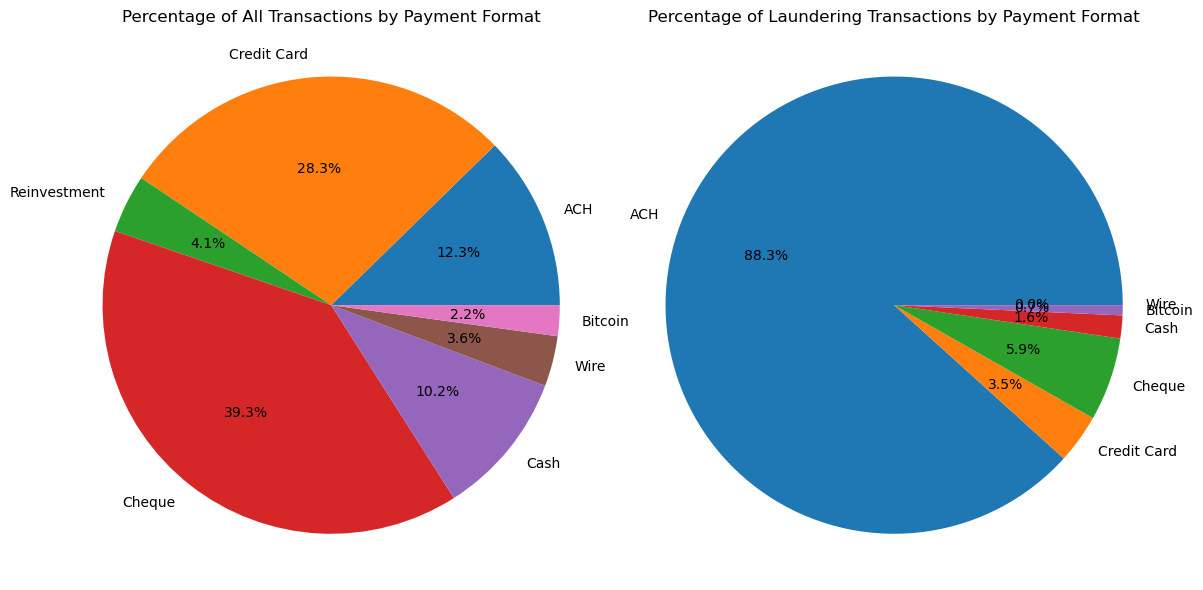

In [31]:
# Group and count transactions by 'payment_format'
payment_format_counts = data_df.groupBy("payment_format").count()

# Calculate the percentage of transactions for each 'payment_format'
total_count = data_df.count()
payment_format_counts = payment_format_counts.withColumn("payment_format_perc", (col("count") / total_count) * 100)

# Convert to Pandas DataFrame for plotting
payment_format_pandas_df = payment_format_counts.toPandas()

# Create pie chart for 'payment_format' for all transactions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.pie(payment_format_pandas_df["payment_format_perc"], labels=payment_format_pandas_df["payment_format"], autopct='%1.1f%%')
plt.title("Percentage of All Transactions by Payment Format")
plt.axis('equal')

# Group and count laundering transactions by 'payment_format'
payment_format_launder_counts = data_df.select(col('is_laundering'), col('payment_format')).filter(col('is_laundering') == 1).groupBy("payment_format").count()

# Calculate the percentage of laundering transactions for each 'payment_format'
launder_total_count = payment_format_launder_counts.agg({"count": "sum"}).collect()[0][0]
payment_format_launder_counts = payment_format_launder_counts.withColumn("payment_format_launder_perc", (col("count") / launder_total_count) * 100)

# Convert to Pandas DataFrame for plotting
payment_format_launder_pandas_df = payment_format_launder_counts.toPandas()

# Create pie chart for 'payment_format' for laundering transactions
plt.subplot(1, 2, 2)
plt.pie(payment_format_launder_pandas_df["payment_format_launder_perc"], labels=payment_format_launder_pandas_df["payment_format"], autopct='%1.1f%%')
plt.title("Percentage of Laundering Transactions by Payment Format")
plt.axis('equal')

# Show the pie charts
plt.tight_layout()
plt.show()


23/10/26 15:51:43 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


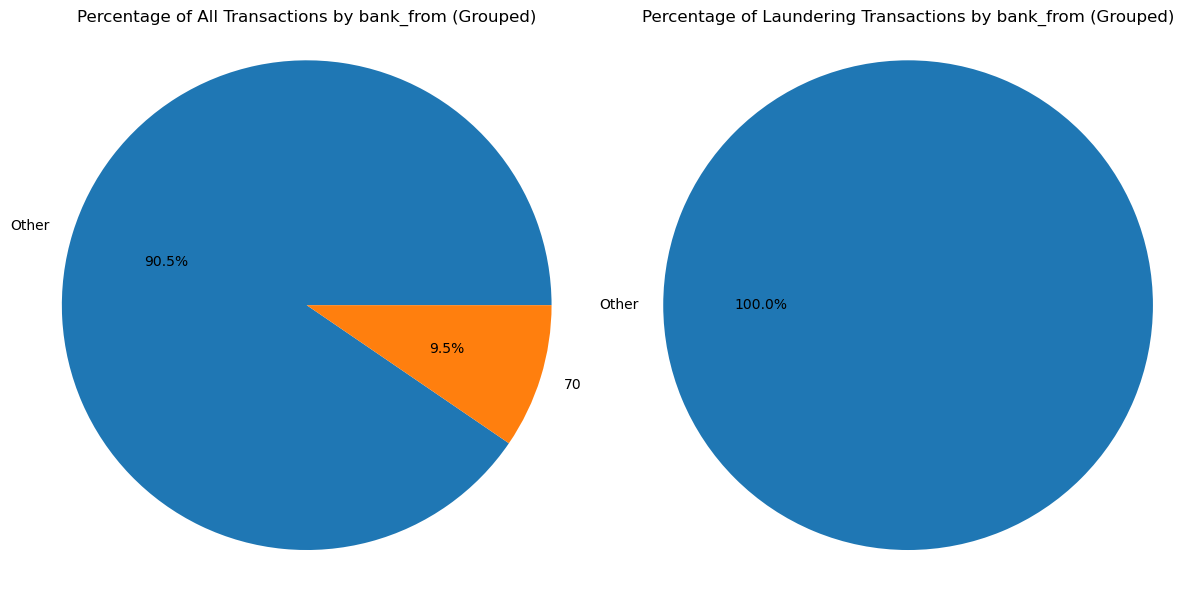

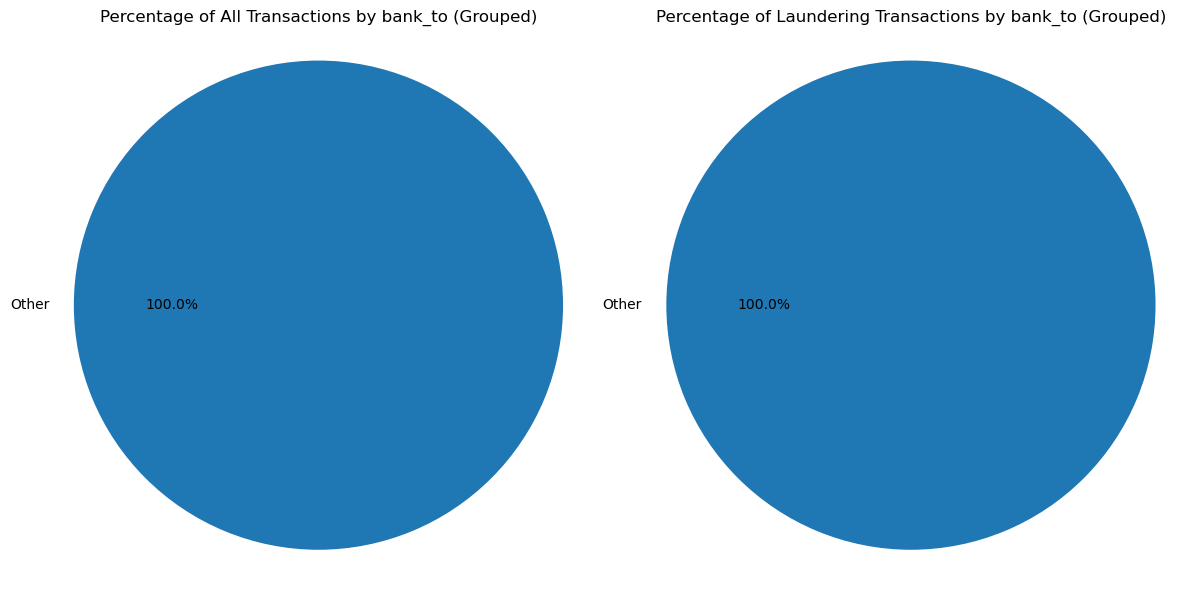

In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, sum as _sum
import matplotlib.pyplot as plt
import pandas as pd

spark = SparkSession.builder.appName("LaunderingCharts").getOrCreate()

csv_file_path = '/common/users/shared/cs543_group4/clean_data/aml_clean_data.csv'
data_df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

# Function to create pie charts for a given column with grouping of small categories
def create_pie_charts_with_grouping(column_name, threshold=0.1):
    # Group and count transactions by the given column
    counts = data_df.groupBy(column_name).count()

    # Calculate the percentage of transactions for each category
    total_count = data_df.count()
    counts = counts.withColumn(f"{column_name}_perc", (col("count") / total_count) * 100)

    # Group smaller categories into 'Other'
    threshold_value = threshold / 100 * total_count
    counts = counts.withColumn('Category', 
                               when(col("count") < threshold_value, 'Other').otherwise(col(column_name)))
    grouped_counts = counts.groupBy('Category').sum(f"{column_name}_perc")

    # Convert to Pandas DataFrame for plotting
    pandas_df = grouped_counts.toPandas()

    # Create pie chart for all transactions
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.pie(pandas_df["sum("+f"{column_name}_perc"+")"], labels=pandas_df["Category"], autopct='%1.1f%%')
    plt.title(f"Percentage of All Transactions by {column_name} (Grouped)")
    plt.axis('equal')

    # Repeat the process for laundering transactions
    launder_counts = data_df.select(col('is_laundering'), col(column_name)).filter(col('is_laundering') == 1).groupBy(column_name).count()
    launder_total_count = launder_counts.agg({"count": "sum"}).collect()[0][0]
    launder_counts = launder_counts.withColumn(f"{column_name}_launder_perc", (col("count") / launder_total_count) * 100)
    launder_counts = launder_counts.withColumn('Category', 
                                               when(col("count") < threshold_value, 'Other').otherwise(col(column_name)))
    grouped_launder_counts = launder_counts.groupBy('Category').sum(f"{column_name}_launder_perc")

    launder_pandas_df = grouped_launder_counts.toPandas()

    # Create pie chart for laundering transactions
    plt.subplot(1, 2, 2)
    plt.pie(launder_pandas_df["sum("+f"{column_name}_launder_perc"+")"], labels=launder_pandas_df["Category"], autopct='%1.1f%%')
    plt.title(f"Percentage of Laundering Transactions by {column_name} (Grouped)")
    plt.axis('equal')

    # Show the pie charts
    plt.tight_layout()
    plt.show()

# Create grouped pie charts for 'bank_from'
create_pie_charts_with_grouping("bank_from")

# Create grouped pie charts for 'bank_to'
create_pie_charts_with_grouping("bank_to")


In [7]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, sum as _sum
import matplotlib.pyplot as plt
import pandas as pd
#initialize Spark
spark = SparkSession.builder \
    .appName("MoneyLaunderingDetectionVisualization") \
    .config("spark.driver.memory", "12g") \
    .config("spark.driver.maxResultSize", "2g") \
    .config("spark.executor.memory", "16g") \
    .getOrCreate()

23/10/26 15:48:09 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [8]:

csv_file_path = '/common/users/shared/cs543_group4/clean_data/aml_clean_data.csv'
data_df = spark.read.csv(csv_file_path, header=True, inferSchema=True)


# Extract the 'amount_from_usd' for all transactions
all_amounts = data_df.select('amount_from_usd').toPandas()

# Extract the 'amount_from_usd' for laundering transactions
launder_amounts = data_df.filter(col('is_laundering') == 1).select('amount_from_usd').toPandas()

# Create box plots
plt.figure(figsize=(10, 6))

# Box plot for all transactions
plt.subplot(1, 2, 1)
plt.boxplot(all_amounts['amount_from_usd'], patch_artist=True)
plt.title('Box Plot of amount_from_usd (All Transactions)')
plt.ylabel('Amount (USD)')

# Box plot for laundering transactions
plt.subplot(1, 2, 2)
plt.boxplot(launder_amounts['amount_from_usd'], patch_artist=True)
plt.title('Box Plot of amount_from_usd (Laundering Transactions)')
plt.ylabel('Amount (USD)')

# Show the box plots
plt.tight_layout()
plt.show()


23/10/26 15:50:46 ERROR TaskSetManager: Total size of serialized results of 257 tasks (1027.6 MiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
23/10/26 15:50:46 WARN TaskSetManager: Lost task 256.0 in stage 2.0 (TID 632) (jupyter.cs.rutgers.edu executor driver): TaskKilled (Tasks result size has exceeded maxResultSize)
23/10/26 15:50:47 ERROR TaskSetManager: Total size of serialized results of 258 tasks (1031.5 MiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
23/10/26 15:50:47 WARN TaskSetManager: Lost task 252.0 in stage 2.0 (TID 628) (jupyter.cs.rutgers.edu executor driver): TaskKilled (Tasks result size has exceeded maxResultSize)
23/10/26 15:50:47 WARN TaskSetManager: Lost task 272.0 in stage 2.0 (TID 648) (jupyter.cs.rutgers.edu executor driver): TaskKilled (Stage cancelled)
23/10/26 15:50:47 WARN TaskSetManager: Lost task 268.0 in stage 2.0 (TID 644) (jupyter.cs.rutgers.edu executor driver): TaskKilled (Stage cancelled)
23/10/26 15:50:47 WARN TaskSetManager:

Py4JJavaError: An error occurred while calling o50.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Total size of serialized results of 257 tasks (1027.6 MiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:971)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2263)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2284)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2303)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2328)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1019)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1018)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:448)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:3997)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4167)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:526)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4165)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:118)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:195)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:103)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:827)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:65)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4165)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3994)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)


In [ ]:
pip install seaborn
